<a href="https://colab.research.google.com/github/tomasb199/DM---Weather/blob/master/OZNAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OZNAL project
## Weather temperature prediction

Zdroje:
https://sci-hub.tw/https://doi.org/10.1007/978-3-642-02481-8_70

https://sci-hub.tw/https://doi.org/10.1016/j.protcy.2012.05.047

https://ieeexplore.ieee.org/document/8473167

https://ieeexplore.ieee.org/document/8117862

In [0]:
%tensorflow_version 2.x
#%load_ext tensorboard
!pip install geopandas
import tensorflow as tf
from tensorflow import keras
#!pip install git+https://github.com/tensorflow/docs
#import tensorflow_docs as tfdocs
#import tensorflow_docs.plots
#import tensorflow_docs.modeling
#from keras.layers import LSTM, Dense, Dropout, Bidirectional
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#plt.style.use('default')
import pandas as pd
import numpy
import seaborn
import sklearn
import statistics
from matplotlib.ticker import MaxNLocator
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model, tree
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
#
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

import librosa
import datetime
import os
import math

import descartes
import geopandas

import PIL.Image
from io import BytesIO
from IPython.display import Image, display

from google.colab import drive
drive.mount('/content/drive/')


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Load data:

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,station,county,longitude,latitude,rain,temp,wetb,dewpt,vappr,rhum,msl,wdsp,wddir,ww,w,sun,vis,clht,clamt
date,,,,,,,,,,,,,,,,,,,
1989-01-01 00:00:00,Cork_Airport,Cork,-8.485,51.842,0.0,9.1,8.7,8.3,10.9,95.0,1036.3,13.0,190.0,10.0,22.0,0.0,10000.0,22.0,7.0
1989-01-01 01:00:00,Cork_Airport,Cork,-8.485,51.842,0.0,9.0,8.7,8.4,11.0,96.0,1036.2,13.0,190.0,10.0,22.0,0.0,8000.0,4.0,8.0
1989-01-01 02:00:00,Cork_Airport,Cork,-8.485,51.842,0.0,8.9,8.5,8.1,10.8,95.0,1036.0,12.0,190.0,10.0,22.0,0.0,8000.0,4.0,8.0
1989-01-01 03:00:00,Cork_Airport,Cork,-8.485,51.842,0.0,9.0,8.7,8.4,11.0,96.0,1035.9,11.0,190.0,10.0,22.0,0.0,8000.0,4.0,8.0
1989-01-01 04:00:00,Cork_Airport,Cork,-8.485,51.842,0.0,9.0,8.6,8.2,10.8,95.0,1035.8,10.0,190.0,10.0,22.0,0.0,10000.0,14.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00,Malin_head,Donegal,-7.339,55.372,0.5,4.3,3.4,2.1,7.1,85.0,984.2,21.0,260.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-31 20:00:00,Malin_head,Donegal,-7.339,55.372,0.4,5.7,4.2,2.0,7.0,76.0,983.5,21.0,220.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-31 21:00:00,Malin_head,Donegal,-7.339,55.372,1.1,4.7,3.8,2.5,7.3,85.0,983.7,24.0,220.0,NaN,NaN,NaN,NaN,NaN,NaN



 Dataset info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4218054 entries, 1989-01-01 00:00:00 to 2017-12-31 23:00:00
Data columns (total 19 columns):
 #   Column     Dtype  
---  ------     -----  
 0   station    object 
 1   county     object 
 2   longitude  float64
 3   latitude   float64
 4   rain       float64
 5   temp       float64
 6   wetb       float64
 7   dewpt      float64
 8   vappr      float64
 9   rhum       float64
 10  msl        float64
 11  wdsp       float64
 12  wddir      float64
 13  ww         float64
 14  w          float64
 15  sun        float64
 16  vis        float64
 17  clht       float64
 18  clamt      float64
dtypes: float64(17), object(2)
memory usage: 643.6+ MB
Cork_Airport
-----------------------------------------------------------------
Moore_Park
-----------------------------------------------------------------
Roches_Point
-----------------------------------------------------------------
SherkinIsland
------------------------------

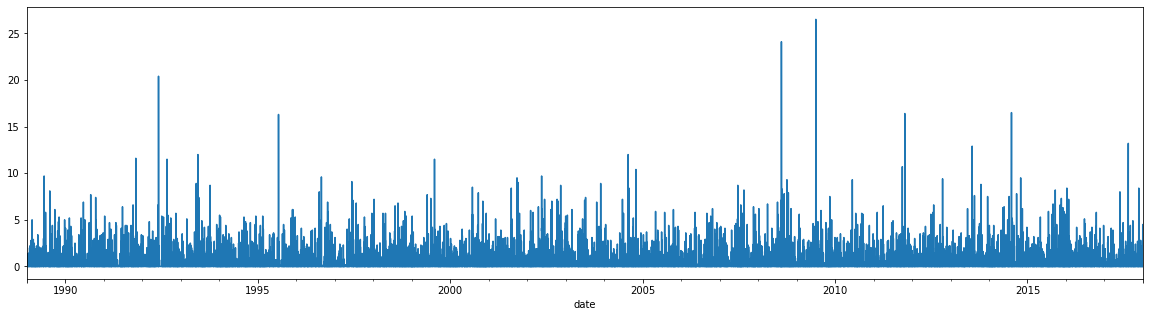

c: temp


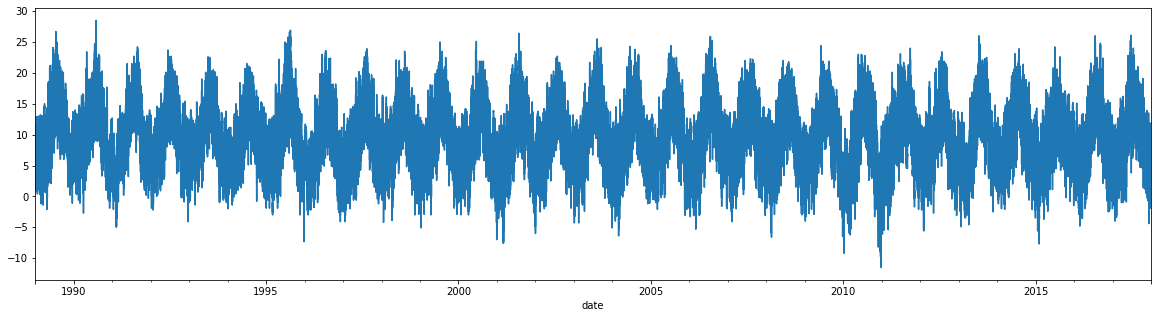

c: wetb


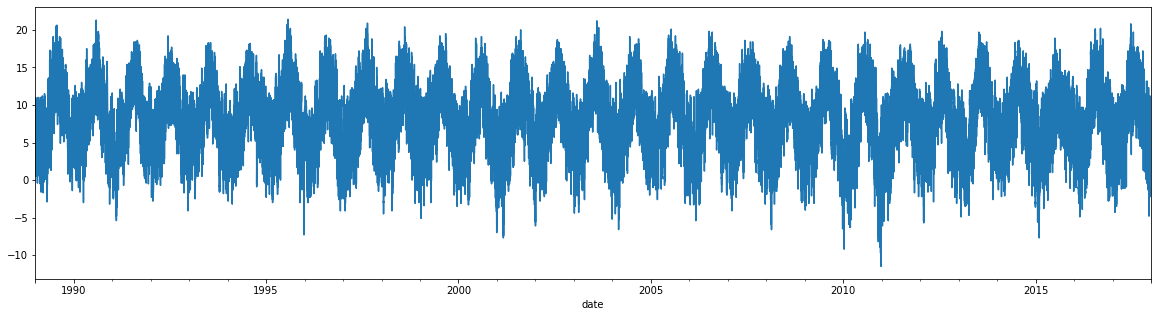

c: dewpt


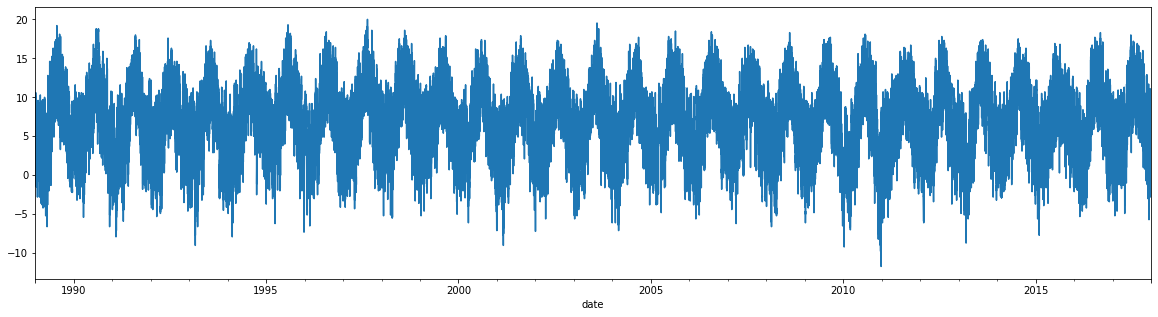

c: vappr


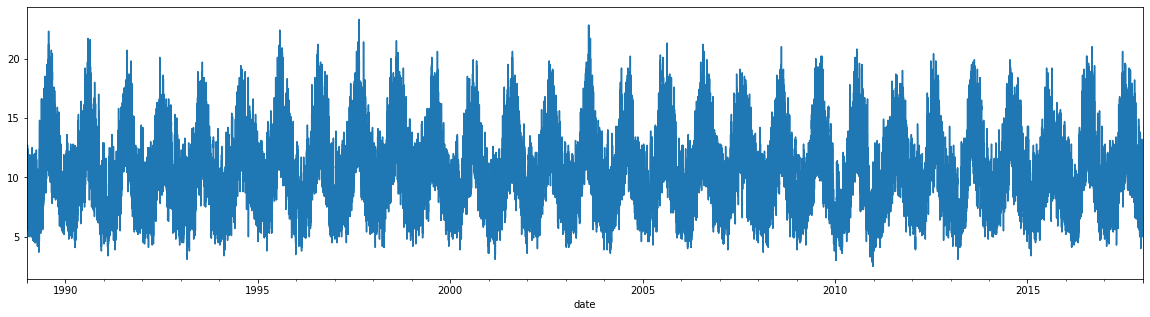

c: rhum


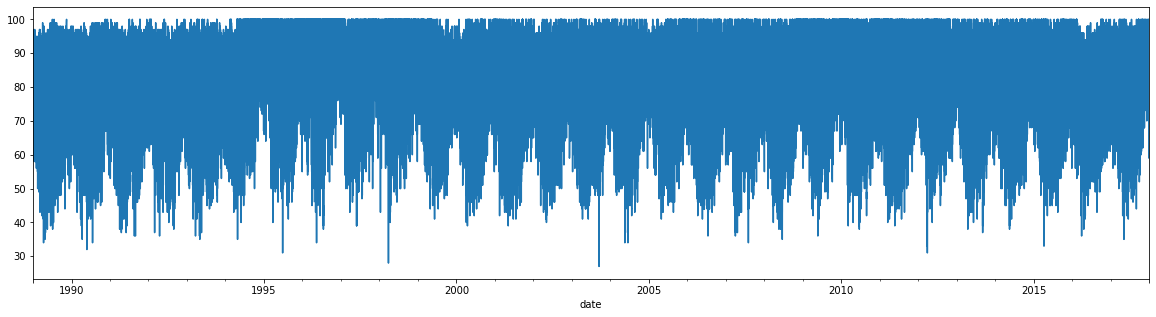

c: msl


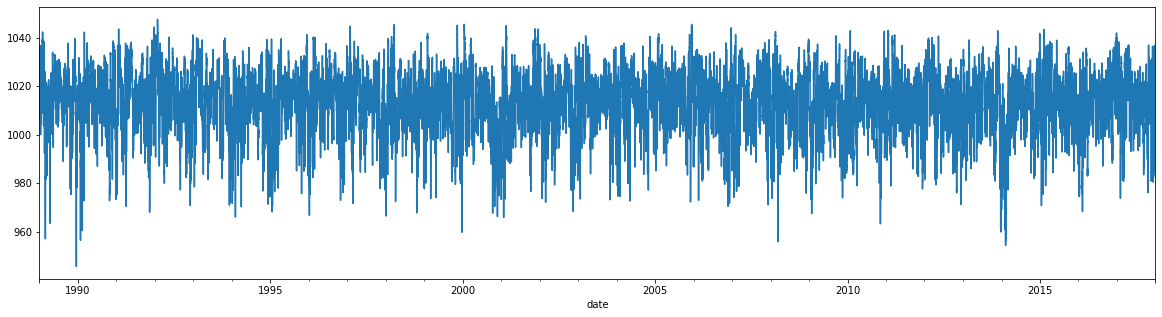

c: wdsp


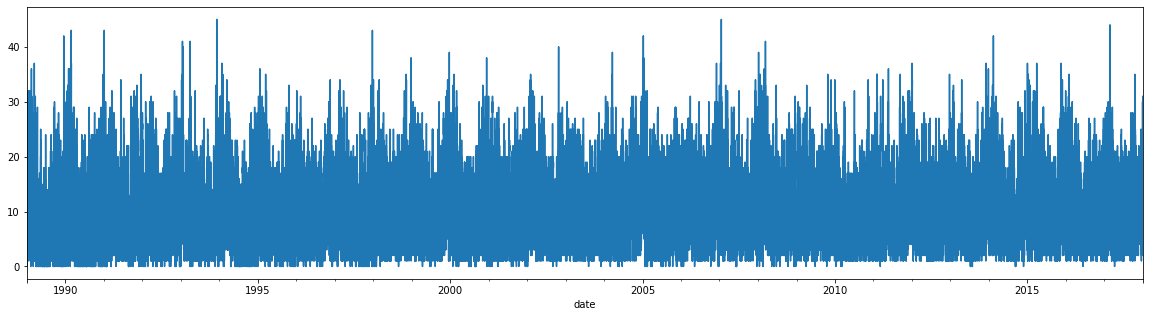

c: wddir


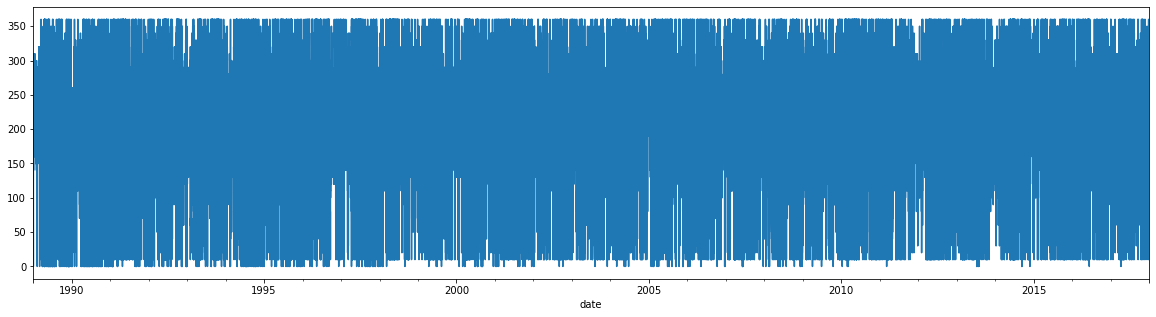

c: ww


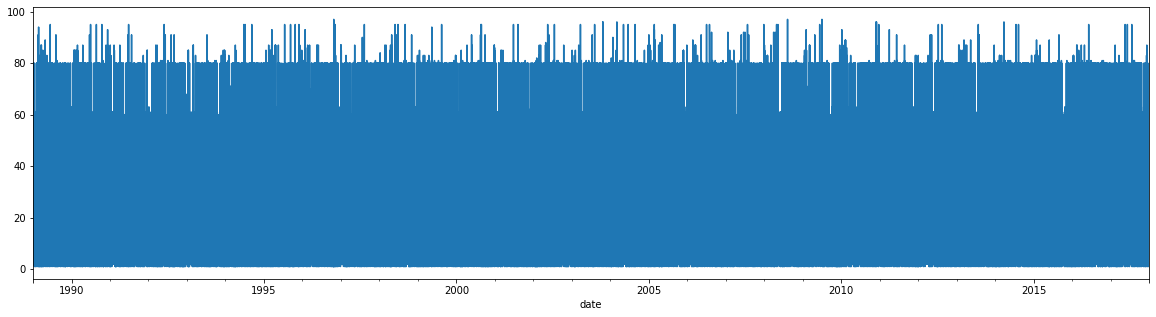

c: w


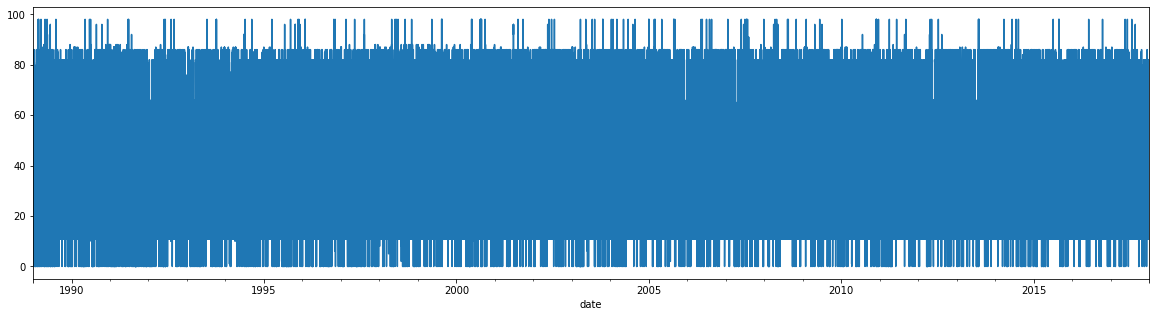

c: sun


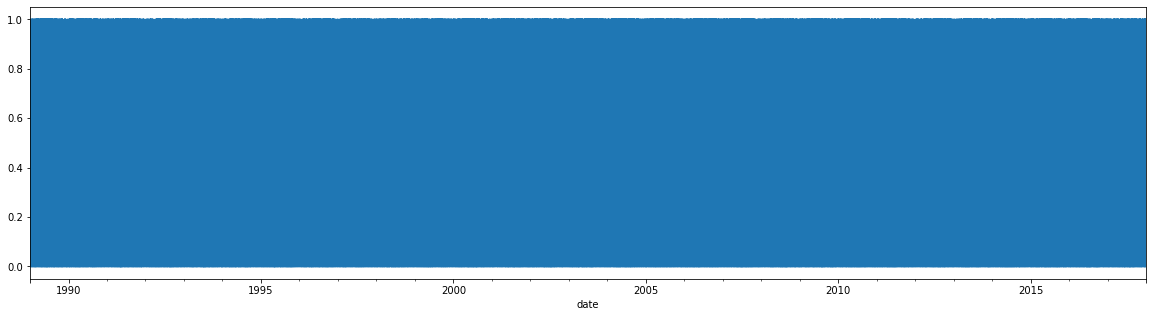

c: vis


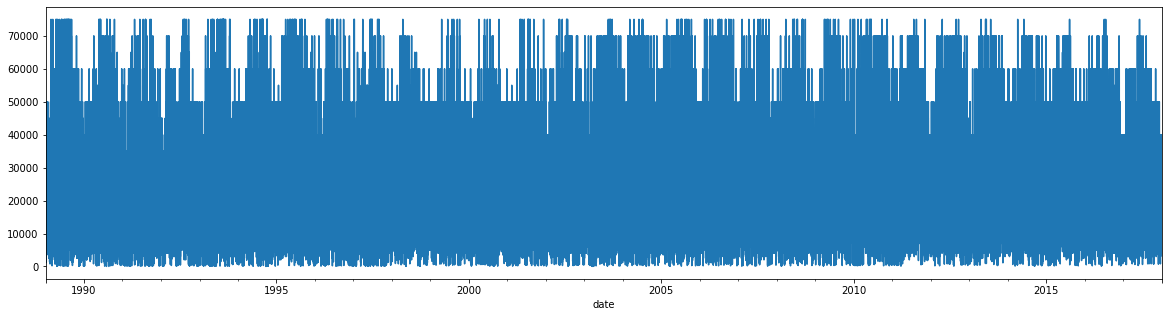

c: clht


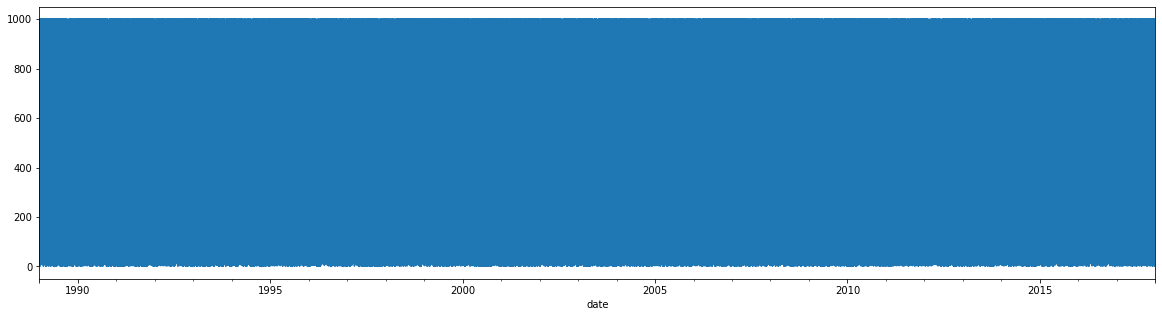

c: clamt


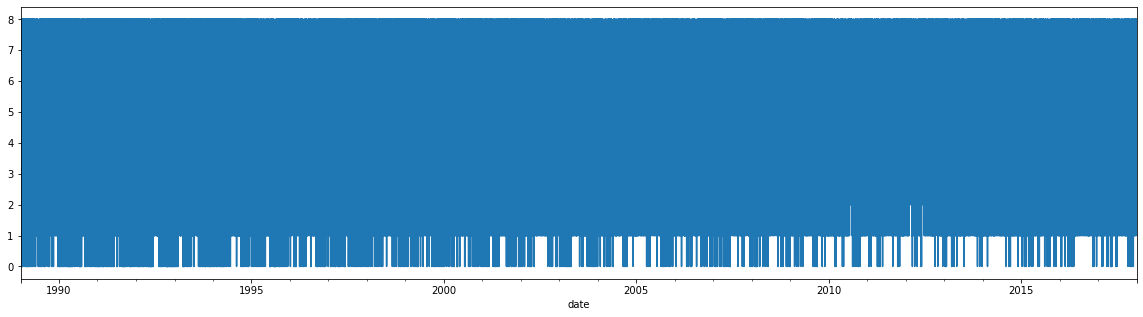

-----------------------------------------------------------------
PhoenixPark
-----------------------------------------------------------------
Dunsany
-----------------------------------------------------------------
Mullingar
-----------------------------------------------------------------
Athenry
-----------------------------------------------------------------
Mace_Head
-----------------------------------------------------------------
Mt_Dillon
-----------------------------------------------------------------
Belmullet
-----------------------------------------------------------------
Claremorris
-----------------------------------------------------------------
Knock_Airport
-----------------------------------------------------------------
Newport
-----------------------------------------------------------------
Markree
-----------------------------------------------------------------
Ballyhaise
-----------------------------------------------------------------
Finner
--------------

In [0]:
# load dataset from google drive
weather_datapath = "/content/drive/My Drive/irish_weather_dataset/hourly_irish_weather.csv"
weather_data = pd.read_csv(weather_datapath, index_col=0)

# index by date
weather_data['date'] = pd.to_datetime(weather_data['date'], infer_datetime_format=True)
weather_data.set_index('date', inplace=True)

# display dataset info
display(weather_data)
print("\n Dataset info:")
weather_data.info()

# display info for each station
weather_stations = {}
# cez vsetky stanice
for i,station in enumerate(weather_data['station'].unique()):
  weather_station = weather_data[weather_data.station == station]
  pd.DataFrame(weather_station)
  weather_stations[station] = weather_station
  print(station)
  # cez vsetky atributy(stlpce)
  for ii,c in enumerate(weather_station.columns):
    # display graphs for dublin airport
    if station == 'Dublin_Airport': 
      if ii > 3: # skip first attributes
        print(f"c: {c}")
        weather_station[c].plot(figsize=(20,5))
        plt.show()
  # weather_station.info()
  print('-----------------------------------------------------------------')

# pocitanie chybajucich zaznamov
max_zaznamov_perstation = 254208 #const

# vypocitaj uplnost dat pre kazdu stanicu
print("\nUplnost dat:")
for station in weather_stations:
  print(station + "\t" + str(max_zaznamov_perstation - len(weather_stations[station])) + "\t" + str(len(weather_stations[station]) / max_zaznamov_perstation * 100)[:4] + "%")

# load Ireland map
ireland_zipfile = "zip:///content/drive/My Drive/irish_weather_dataset/Ireland.shp.zip"
ireland_mapdata = geopandas.read_file(ireland_zipfile)

,station,longitude,latitude,mean_temp,mean_rain
0,Cork_Airport,-8.485,51.842,9.913446,0.139300
254208,Moore_Park,-8.258,52.158,10.088536,0.117200
380615,Roches_Point,-8.240,51.789,10.118767,0.079184
615502,SherkinIsland,-9.423,51.472,11.134588,0.121254
735357,Valentia_Observatory,-10.238,51.936,11.129859,0.180864
989564,Gurteen,-8.005,53.052,9.530194,0.107977
1076539,Shannon_Airport,-8.917,52.687,10.715685,0.114588
1330747,JohnstownII,-6.491,52.292,10.254473,0.119115
1444770,Oak_Park,-6.909,52.857,9.934647,0.096741
1571177,Casement,-6.437,53.303,9.835442,0.087763


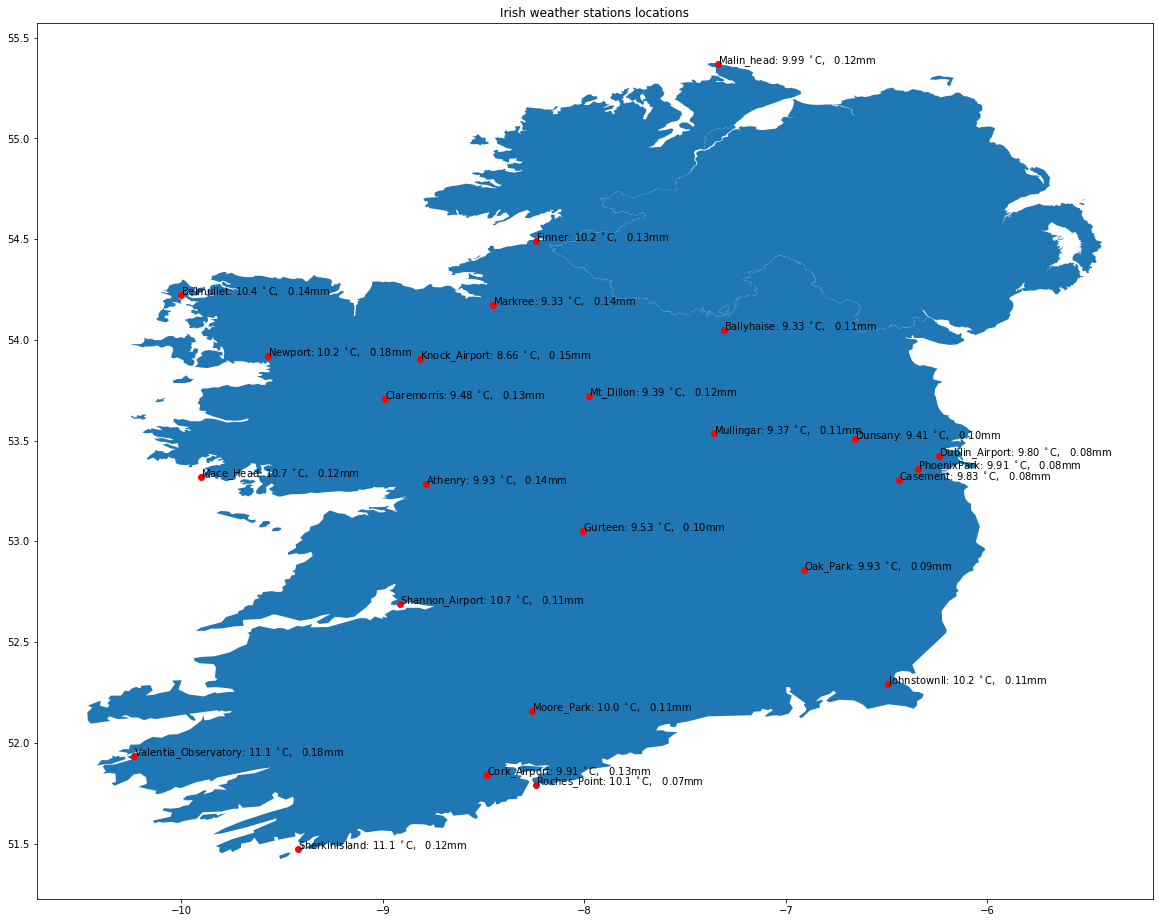

In [0]:
# reset index, so groupby can be used
weather_data = weather_data.reset_index()

# weather station location visualisation
weather_stations_local = pd.DataFrame(weather_data, columns=['station', 'longitude', 'latitude'])
weather_stations_local.drop_duplicates(keep='first', inplace=True)

# add mean temperature for each weather station in degrees Celsius
weather_stations_local['mean_temp'] = weather_data.groupby(by='station')['temp'].transform('mean')
# add mean rain for each weather station in mm
weather_stations_local['mean_rain'] = weather_data.groupby(by='station')['rain'].transform('mean')

display(weather_stations_local)
 

ax = ireland_mapdata.plot(figsize = (20, 60))
gdf = geopandas.GeoDataFrame(weather_stations_local, geometry=geopandas.points_from_xy(weather_stations_local['longitude'], weather_stations_local['latitude']))

for index, station in weather_stations_local.iterrows():
  plt.text(station['longitude'], 
           station['latitude'], 
           station['station'] + ": " + str(station['mean_temp'])[:4] + " $^\circ$C,   " + str(station['mean_rain'])[:4] + "mm", 
           color='black')

gdf.plot(ax=ax, color='red')
plt.title("Irish weather stations locations")

plt.show()

# return index back to date
weather_data.set_index('date', inplace=True)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:483: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  **kws)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:483: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  **kws)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:483: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  **kws)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:483: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it t

Text(0.5, 1.0, 'Boxplot diagram for temperature')

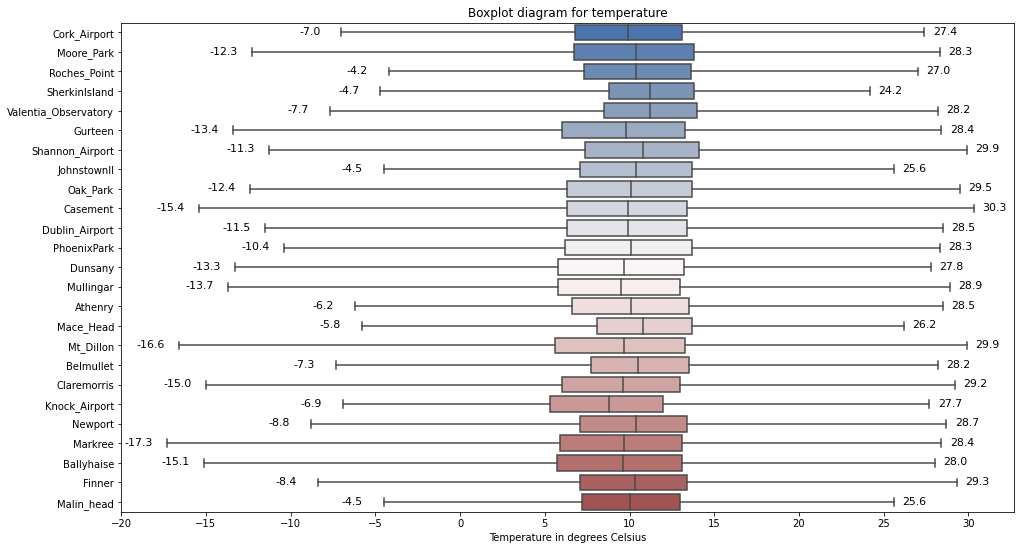

In [0]:
# Boxplot diagram for temperature
plt.figure(figsize=(16, 9))
boxplot = seaborn.boxplot(x="temp", y="station", data=weather_data,
            whis="range", palette="vlag", order=weather_data['station'].unique())

mins = weather_data.groupby(['station'], sort=False)['temp'].min()
maxs = weather_data.groupby(['station'], sort=False)['temp'].max()

for ytick in boxplot.get_yticks():
    boxplot.text(mins[ytick] - 2.5, ytick + 0.1, mins[ytick], size='11', color='black', weight=None)
    boxplot.text(maxs[ytick] + 0.5, ytick + 0.1, maxs[ytick], size='11', color='black', weight=None)

maxf = math.floor(weather_data['temp'].max())
minf = math.floor(weather_data['temp'].min())

arr = np.arange(minf - minf % 5, maxf - maxf % 5 + 5, 5.0)
#arr = np.insert(arr, 0, min)
#arr = np.insert(arr, arr.size, max)
plt.xticks(arr)
plt.xlabel("Temperature in degrees Celsius")
plt.ylabel("")
plt.title("Boxplot diagram for temperature")




Correlation matrix

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7108a7e0b8>,
      dtype=object)

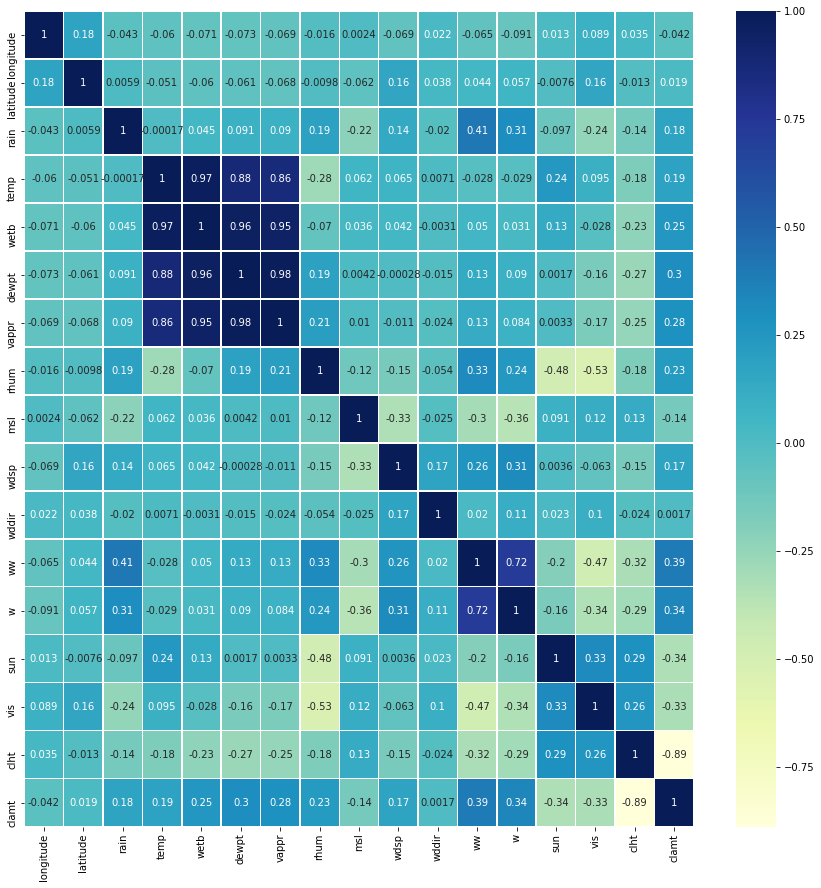

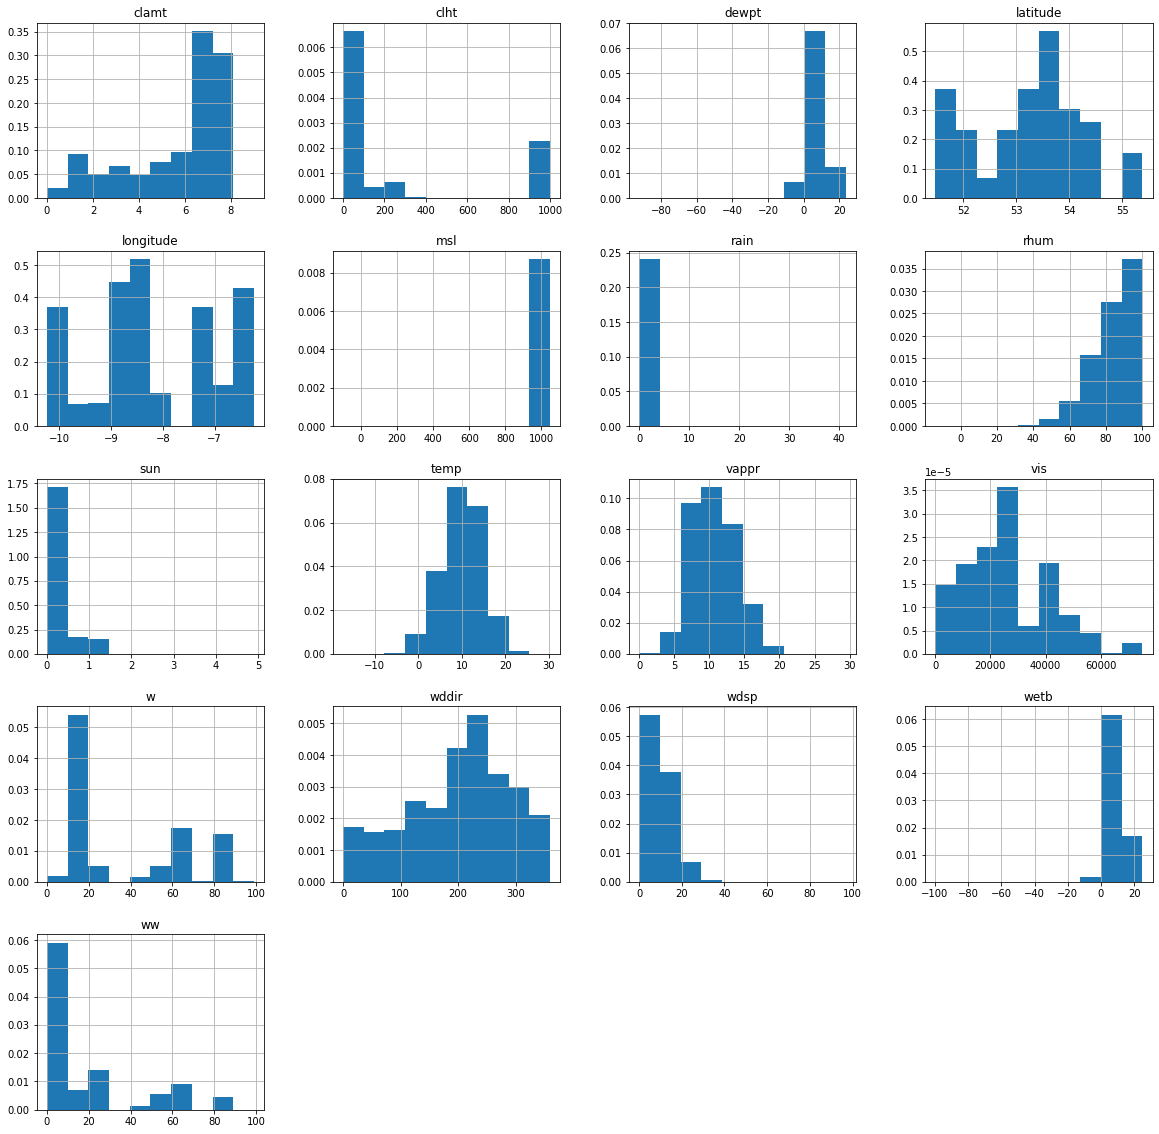

In [0]:
# correlation matrix

# weather_data['day'] = weather_data.index.dayofyear
# weather_data['hour'] = weather_data.index.hour
# weather_data['month'] = weather_data.index.month

fig, ax = plt.subplots(figsize=(15,15))
seaborn.heatmap(weather_data.corr(), annot=True, linewidths=.5, ax=ax, cmap="YlGnBu")

# histogram
weather_data.hist(figsize=(20,20), density=True)

In [0]:
### statistics of one station (Dublin_Airport)
pd.set_option('display.max_rows', 15)

#for station in weather_data['station'].unique():
 # print(station)
  #if(station == 'Dublin_Airport'):

dublinAirport_df = weather_data[weather_data.station == 'Dublin_Airport']
dublinAirport_df = dublinAirport_df.drop(['station', 'county', 'latitude', 'longitude'], axis=1)
#display(dublinAirport_df)
#dublinAirport_df = dublinAirport_df.dropna()

# create statistics data frame
# add min
dublinAirportStats_df = pd.DataFrame(dublinAirport_df.min(), index=dublinAirport_df.columns,  columns=['min'])
# add max
dublinAirportStats_df['max'] = dublinAirport_df.max()
# add mean
dublinAirportStats_df['mean'] = dublinAirport_df.mean()
# add median - 50 percentil
dublinAirportStats_df['median'] = dublinAirport_df.median()
# add 10 percentil
dublinAirportStats_df['quantile(10)'] = dublinAirport_df.quantile(0.1)
# add 90 percentil
dublinAirportStats_df['quantile(90)'] = dublinAirport_df.quantile(0.9)
# add mode (modus)
try:
  dublinAirportStats_df['modus'] = dublinAirport_df.mode().T
except:
  print(station + " modus calc error\n")
# add standard deviation
dublinAirportStats_df['std'] = dublinAirport_df.std()
# add var (rozptyl)
dublinAirportStats_df['var'] = dublinAirport_df.var().round(decimals=1)
# add null values
dublinAirportStats_df['isna'] = dublinAirport_df.isna().sum(axis = 0)
# add count
dublinAirportStats_df['count'] = dublinAirport_df.count()

display(dublinAirportStats_df)


#display(weather_data.std(numeric_only=True))


,min,max,mean,median,quantile(10),quantile(90),modus,std,var,isna,count
rain,0.0,26.5,0.087024,0.0,0.0,0.1,0.0,0.420453,0.2,0,254208
temp,-11.5,28.5,9.800368,9.9,3.3,16.1,10.0,4.927241,24.3,0,254208
wetb,-11.5,21.4,8.397860,8.6,2.4,14.0,9.0,4.383696,19.2,0,254208
dewpt,-11.7,20.0,6.844648,7.0,0.8,12.6,7.9,4.457536,19.9,0,254208
vappr,2.5,23.3,10.321057,10.0,6.5,14.6,10.4,3.094082,9.6,1,254207
rhum,27.0,100.0,82.885581,85.0,66.0,97.0,100.0,11.881378,141.2,1,254207
msl,945.6,1047.5,1013.674437,1014.7,997.2,1028.7,1019.7,12.398488,153.7,0,254208
wdsp,0.0,45.0,10.555313,10.0,4.0,18.0,7.0,5.683672,32.3,0,254208
wddir,0.0,360.0,205.281955,230.0,80.0,300.0,240.0,84.199172,7089.5,1,254207
ww,1.0,97.0,15.087114,2.0,2.0,60.0,2.0,22.222059,493.8,0,254208


# RNN LSTM (verzia s viacerymi atributmi) stateful=False
## vyuziva casove okna

In [0]:
###LSTM RNN###
dataset = weather_stations['Dublin_Airport']
dataset = dataset.drop(columns=['station', 'county', 'longitude', 'latitude', 'wetb', 'dewpt'], axis=1)

# fill missing values with median
dataset = dataset.fillna(dataset.median())

# add time collums
dataset['day'] = dataset.index.dayofyear #1-365 day of year
dataset['hour'] = dataset.index.hour

dataset = dataset[:50000]

# vyber atributy s najvyssimi korelaciami
#dataset = dataset.filter(['temp', 'day', 'hour', 'vappr', 'rhum', 'sun', 'clht', 'clamt'])
dataset = dataset.filter(['temp'])
display(dataset[:3])

#############################################PREDICTION PARAMETERS#######################################
# na zaklade kolkych hodin dozadu sa bude predpovedat n hodin dopredu
sequence_length = 48
prediction_length = 1
#########################################################################################################

## shift 'temp' data by n hours because of prediction (y label), shiftnutie je spravene pri vytvari okien nizsie
temp_shifted = dataset[['temp']]#.shift(-prediction_length)
#dataset = dataset.drop(columns=['temp'])
x_data = dataset.values[0:-prediction_length]
print(f"\nx_data shape: {x_data.shape}")
y_data = temp_shifted.values[:-prediction_length]
print(f"y_data shape: {y_data.shape}")

# train and test set 80:20
training_data_len = math.ceil(len(x_data) * .8)
print(f"Training data len: {training_data_len}, Test data len: {len(x_data)-training_data_len}")
x_train = x_data[0:training_data_len]
x_test = x_data[training_data_len:]
print(f"x_train len: {len(x_train)}, x_test len: {len(x_test)}, count: {len(x_train)+len(x_test)}")
print(f"x_train shape: {x_train.shape}, x_test shape: {x_test.shape}")
y_train = y_data[0:training_data_len]
y_test = y_data[training_data_len:]
print(f"y_train len: {len(y_train)}, y_test len: {len(y_test)}, count: {len(y_train)+len(y_test)}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

#Scale the data
scaler_x = MinMaxScaler(feature_range=(0,1))
x_train_scaled = scaler_x.fit_transform(x_train)
x_test_scaled = scaler_x.transform(x_test)
scaler_y = MinMaxScaler(feature_range=(0,1))
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

###########################################TRAIN DATASET###############################################################
# size of new dataset
_size = training_data_len - sequence_length - prediction_length

x_train_window = np.zeros(shape=(_size, sequence_length, x_data.shape[1]), dtype=np.float16)
y_train_window = np.zeros(shape=(_size, prediction_length, y_data.shape[1]), dtype=np.float16)

for i in range(_size):
  x_train_window[i] = x_train_scaled[i:i+sequence_length]
  y_train_window[i] = y_train_scaled[i+sequence_length:i+sequence_length+prediction_length]

print(f"x_train_window shape:{x_train_window.shape}, y_train_window shape: {y_train_window.shape}")

##########################################VALIDATION DATASET############################################################
_size = len(x_test) - sequence_length - prediction_length

x_valid_window = np.zeros(shape=(_size, sequence_length, x_data.shape[1]), dtype=np.float16)
y_valid_window = np.zeros(shape=(_size, prediction_length, y_data.shape[1]), dtype=np.float16)

for i in range(_size):
  x_valid_window[i] = x_test_scaled[i:i+sequence_length]
  y_valid_window[i] = y_test_scaled[i+sequence_length:i+sequence_length+prediction_length]

print(f"x_valid_window shape:{x_valid_window.shape}, y_valid_window shape: {y_valid_window.shape}\n")
#########################################################################################################################

#Build the LSTM model
def create_model():
  model = keras.Sequential()
  model.add(keras.layers.LSTM(units=50, stateful=False, return_sequences=True, input_shape=(x_train_window.shape[1], x_train_window.shape[2],)))
  model.add(keras.layers.Dropout(0.3))
  model.add(keras.layers.LSTM(units=50, stateful=False, return_sequences=False))
  model.add(keras.layers.Dropout(0.3))
  model.add(keras.layers.Dense(prediction_length))
  model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae', 'mape'])
  model.summary()
  return model

model = create_model()
keras.backend.set_epsilon(1) # potrebne pre metriku mape

#Early stopping
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
#Train the model
model.fit(x_train_window, y_train_window, batch_size=64, epochs=30, callbacks=[callback], validation_data=(x_valid_window, y_valid_window))

,temp,day,vappr
date,,,
1989-01-01 00:00:00,6.8,1,8.6
1989-01-01 01:00:00,7.9,1,8.4
1989-01-01 02:00:00,7.9,1,8.3



x_data shape: (49999, 3)
y_data shape: (49999, 1)
Training data len: 40000, Test data len: 9999
x_train len: 40000, x_test len: 9999, count: 49999
x_train shape: (40000, 3), x_test shape: (9999, 3)
y_train len: 40000, y_test len: 9999, count: 49999
y_train shape: (40000, 1), y_test shape: (9999, 1)
x_train_window shape:(39951, 48, 3), y_train_window shape: (39951, 1, 1)
x_valid_window shape:(9950, 48, 3), y_valid_window shape: (9950, 1, 1)

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_58 (LSTM)               (None, 48, 50)            10800     
_________________________________________________________________
dropout_58 (Dropout)         (None, 48, 50)            0         
_________________________________________________________________
lstm_59 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dro

x_test_window shape:(9951, 48, 3), y_test_window shape: (9951, 1, 1)
311/311 [==============================] - 3s 10ms/step - loss: 4.4862e-04 - mse: 4.4865e-04 - mae: 0.0154 - mape: 1.5378
RMSE: 0.7096024790790356
MSE: 0.5035356783151133
MAE 0.5151675302769273


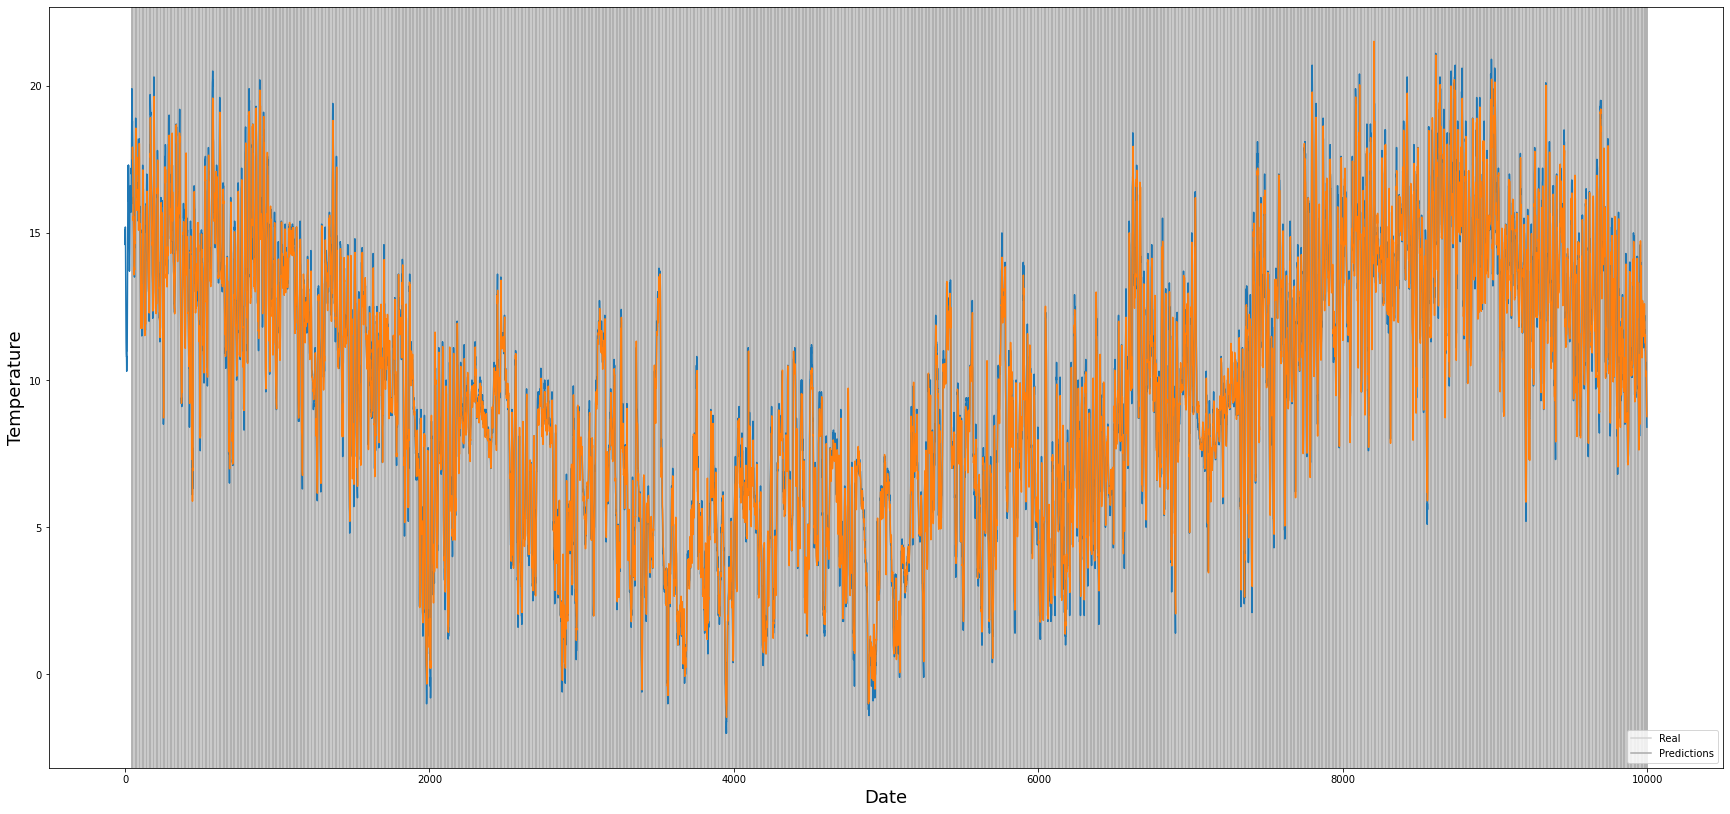

In [0]:
#############################################TESTING DATASET#########################################
_size = math.floor((len(x_test) - sequence_length) / prediction_length)

x_test_window = np.zeros(shape=(_size, sequence_length, x_data.shape[1]), dtype=np.float16)
y_test_window = np.zeros(shape=(_size, prediction_length, y_data.shape[1]), dtype=np.float16)

ii = 0
for i in range(_size):
  x_test_window[i] = x_test_scaled[ii:ii+sequence_length]
  y_test_window[i] = y_test_scaled[ii+sequence_length:ii+sequence_length+prediction_length]
  ii += prediction_length

print(f"x_test_window shape:{x_test_window.shape}, y_test_window shape: {y_test_window.shape}")
#####################################################################################################

# evaluate the model
model.evaluate(x_test_window, y_test_window)

# get the model predicted temperature
predictions = model.predict(x_test_window)
predictions = scaler_y.inverse_transform(predictions)
predictions = predictions.flatten()

# Calculate unscaled MSE, MAE
# b = -(len(x_test)-(_size*prediction_length+sequence_length))
# MSE = mean_squared_error(y_test[sequence_length:b if b !=0 else None], predictions)
#MAE = mean_absolute_error(y_test[sequence_length:b if b !=0 else None], predictions)
MSE = mean_squared_error(y_test[sequence_length:], predictions)
MAE = mean_absolute_error(y_test[sequence_length:], predictions)
print(f'RMSE: {np.sqrt(MSE)}')
print(f'MSE: {MSE}')
print(f'MAE {MAE}')


#Visualize the predictions
predictions = pd.DataFrame(predictions)
predictions.index = pd.RangeIndex(start=sequence_length, stop = len(predictions)+sequence_length, step = 1)

plt.figure(figsize=(30,14))
plt.xlabel('Date', fontsize=18)
plt.ylabel('Temperature', fontsize=18)

idx = 0
i = sequence_length
while i < len(y_test) - prediction_length:
  if idx == 0:
    plt.axvline(x = i, color = 'lightgrey')
    idx += 1
  else:
    plt.axvline(x = i, color = 'darkgrey')
    idx -= 1
  i += prediction_length

plt.plot(y_test)
plt.plot(predictions)

plt.legend(['Real', 'Predictions'], loc='lower right')
plt.show()


# RNN LSTM (iba s jednym atributom - teplotou) stateful=True 
# bez casovych okien

In [0]:
###LSTM RNN###
dataset = weather_stations['Dublin_Airport']
dataset = dataset.drop(columns=['station', 'county', 'longitude', 'latitude', 'wetb', 'dewpt'], axis=1)

dataset = dataset.fillna(dataset.median())

# add time collums
dataset['day'] = dataset.index.dayofyear #1-365 day of year
dataset['hour'] = dataset.index.hour

dataset = dataset[:50000]

dataset = dataset.filter(['temp'])
display(dataset[:3])

#############################################PREDICTION PARAMETERS#######################################
# na zaklade kolkych hodin dozadu sa bude predpovedat n hodin dopredu
sequence_length = 24
prediction_length = 1

if sequence_length < prediction_length:
  print('Invalid prediction parametes!')
#########################################################################################################

## shift 'temp' data by n hours because of prediction (y label), shift je robeny dalej pri vytvarani train/valid datasetu
temp_shifted = dataset[['temp']]#.shift(-prediction_length)
x_data = dataset.values[0:-prediction_length]
print(f"\nx_data shape: {x_data.shape}")
y_data = temp_shifted.values[:-prediction_length]
print(f"y_data shape: {y_data.shape}")


# train and test set 90:10
training_data_len = math.ceil(len(x_data) * .9)
print(f"Training data len: {training_data_len}, Test data len: {len(x_data)-training_data_len}")
x_train = x_data[0:training_data_len]
x_test = x_data[training_data_len:]
print(f"x_train len: {len(x_train)}, x_test len: {len(x_test)}, count: {len(x_train)+len(x_test)}")
print(f"x_train shape: {x_train.shape}, x_test shape: {x_test.shape}")
y_train = y_data[0:training_data_len]
y_test = y_data[training_data_len:]
print(f"y_train len: {len(y_train)}, y_test len: {len(y_test)}, count: {len(y_train)+len(y_test)}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

#Scale the data
scaler_x = MinMaxScaler(feature_range=(0,1))
x_train_scaled = scaler_x.fit_transform(x_train)
x_test_scaled = scaler_x.transform(x_test)
scaler_y = MinMaxScaler(feature_range=(0,1))
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

###########################################TRAIN DATASET###############################################################
a = -(len(x_train_scaled) % sequence_length)
x_train_scaled = x_train_scaled[:a if a != 0 else None] # - modulo aby sa to dalo delit
x_train_scaled = np.reshape(x_train_scaled, ((int)(x_train_scaled.shape[0] / sequence_length), sequence_length, 1))
x_train_scaled = x_train_scaled[:-1] # lebo posledna je nakonci a potom by nevysli y-ony

y_train_skip = np.zeros(shape=(x_train_scaled.shape[0], prediction_length))
iii = 0
for i in range(y_train_scaled.shape[0]):
  try:
    if i % sequence_length == 0 and i != 0:
      y_train_skip[iii] = y_train_scaled.flatten()[i:i+prediction_length] 
      iii += 1
  except: 
    ''''''

print(f"\nx_train_skip shape:{x_train_scaled.shape}, y_train_skip shape: {y_train_skip.shape}")
##########################################VALIDATION DATASET############################################################
# validaciu je mozne spravit aj pomocou okien ak berieme kazde okno ako samostatnu sekvenciu, cize treba resetovat stav modelu, vyriesene callbackom
_size = len(x_test) - sequence_length - prediction_length

x_valid_window = np.zeros(shape=(_size, sequence_length, x_data.shape[1]), dtype=np.float16)
y_valid_window = np.zeros(shape=(_size, prediction_length, y_data.shape[1]), dtype=np.float16)
     
for i in range(_size):
  x_valid_window[i] = x_test_scaled[i:i+sequence_length]
  y_valid_window[i] = y_test_scaled[i+sequence_length:i+sequence_length+prediction_length]

print(f"x_valid_window shape:{x_valid_window.shape}, y_valid_window shape: {y_valid_window.shape}\n")
#########################################################################################################################

#Build the LSTM model
def create_model():
  model = keras.Sequential()
  model.add(keras.layers.LSTM(units=50, stateful=True, return_sequences=True, batch_size=1, input_shape=(x_train_scaled.shape[1],1)))
  model.add(keras.layers.Dropout(0.3))
  model.add(keras.layers.LSTM(units=50, stateful=True, return_sequences=False, batch_size=1))
  model.add(keras.layers.Dropout(0.3))
  model.add(keras.layers.Dense(prediction_length))
  model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae', 'mape'])
  model.summary()
  return model

model = create_model()
keras.backend.set_epsilon(1) # potrebne pre metriku mape

#Early stopping & state resetting
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_end(self, batch, logs={}):
      self.model.reset_states()
    def on_test_batch_begin(self, batch, logs={}):
      self.model.reset_states()
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
#Train the model
model.fit(x_train_scaled, y_train_skip, batch_size=1, epochs=30, callbacks=[callback, ResetStatesCallback()], validation_data=(x_valid_window, y_valid_window))

,temp
date,
1989-01-01 00:00:00,6.8
1989-01-01 01:00:00,7.9
1989-01-01 02:00:00,7.9



x_data shape: (49999, 1)
y_data shape: (49999, 1)
Training data len: 45000, Test data len: 4999
x_train len: 45000, x_test len: 4999, count: 49999
x_train shape: (45000, 1), x_test shape: (4999, 1)
y_train len: 45000, y_test len: 4999, count: 49999
y_train shape: (45000, 1), y_test shape: (4999, 1)

x_train_skip shape:(1874, 24, 1), y_train_skip shape: (1874, 1)
x_valid_window shape:(4974, 24, 1), y_valid_window shape: (4974, 1, 1)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (1, 24, 50)               10400     
_________________________________________________________________
dropout_22 (Dropout)         (1, 24, 50)               0         
_________________________________________________________________
lstm_23 (LSTM)               (1, 50)                   20200     
_________________________________________________________________
dropout_23 

4974/4974 [==============================] - 33s 7ms/step - loss: 8.2566e-04 - mse: 8.2566e-04 - mae: 0.0218 - mape: 2.1757
(4974, 1)
b:-1
RMSE: 0.962561234120921
MSE: 0.9265241294323905
MAE: 0.728788042421987


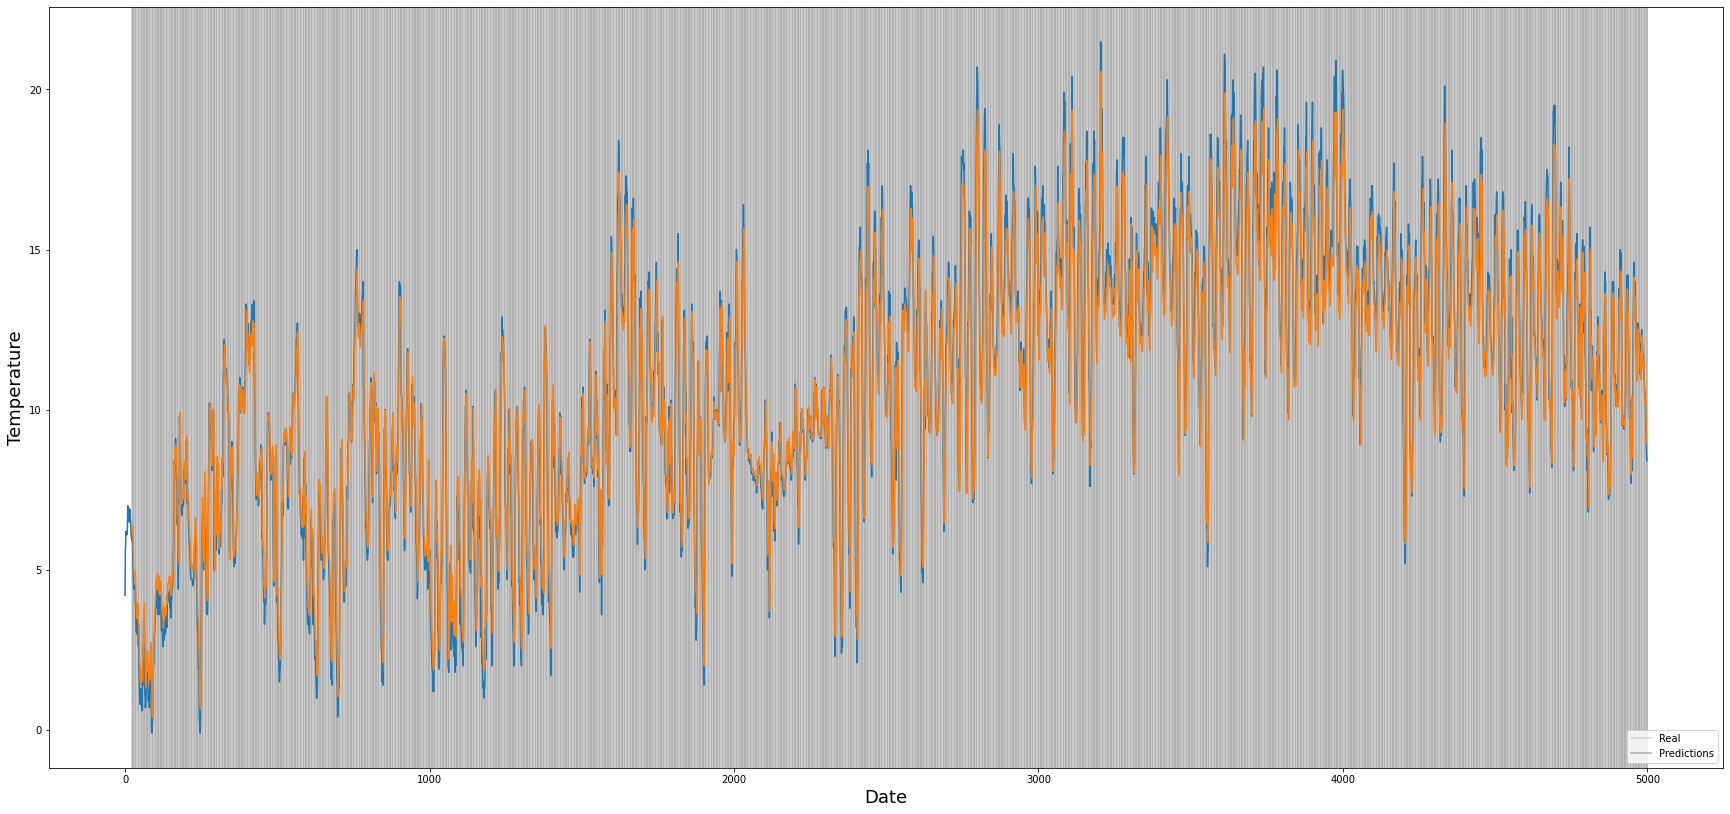

In [0]:
# Evaluate the model
model.evaluate(x_valid_window, y_valid_window, batch_size=1, callbacks=[ResetStatesCallback()])

# Predict
model.reset_states()
predictions = model.predict(x_valid_window, batch_size=1, callbacks=[ResetStatesCallback()])
print(predictions.shape)
predictions = scaler_y.inverse_transform(predictions)
predictions = predictions.flatten()

# Calculate unscaled metrics
b = -(len(x_test)-(_size*prediction_length+sequence_length))
print(f'b:{b}')
MSE = mean_squared_error(y_test[sequence_length:b if b !=0 else None], predictions)
MAE = mean_absolute_error(y_test[sequence_length:b if b != 0 else None], predictions)
print(f'RMSE: {np.sqrt(MSE)}')
print(f'MSE: {MSE}')
print(f'MAE: {MAE}')

#Visualize the data
predictions = pd.DataFrame(predictions)
predictions.index = pd.RangeIndex(start=sequence_length, stop = len(predictions)+sequence_length, step = 1)

plt.figure(figsize=(30,14))
plt.xlabel('Date', fontsize=18)
plt.ylabel('Temperature', fontsize=18)

idx = 0
i = sequence_length
while i < len(y_test) - prediction_length:
  if idx == 0:
    plt.axvline(x = i, color = 'lightgrey')
    idx += 1
  else:
    plt.axvline(x = i, color = 'darkgrey')
    idx -= 1
  i += prediction_length

plt.plot(y_test)
plt.plot(predictions)

plt.legend(['Real', 'Predictions'], loc='lower right')
plt.show()


# Feature selection - SelectKBest (mutual_info_regression)
(filter metod)

In [0]:
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt

###LSTM RNN###
dataset = weather_stations['Dublin_Airport']
dataset = dataset.drop(columns=['station', 'county', 'longitude', 'latitude', 'wetb', 'dewpt'], axis=1)

# dataset = dataset.dropna() #TODO median instead of dropna
dataset = dataset.fillna(dataset.median())

# add time collums
dataset['day'] = dataset.index.dayofyear #1-365 day of year
dataset['hour'] = dataset.index.hour

dataset = dataset[:50000]

# vyber atributy s najvyssimi korelaciami
#dataset = dataset.filter(['day', 'hour', 'vappr', 'rhum', 'sun', 'clht', 'clamt', 'temp'])
#dataset = dataset.filter(['temp'])


#############################################PREDICTION PARAMETERS#######################################
# na zaklade kolkych hodin dozadu sa bude predpovedat n hodin dopredu
sequence_length = 24*7
prediction_length = 1
#########################################################################################################

## shift 'temp' data by n hours because of prediction (y label)
temp_shifted = dataset[['temp']]#.shift(-prediction_length)
#dataset = dataset.drop(columns=['temp'], axis=1)
display(dataset[:3])
#dataset = dataset.drop(columns=['temp'])
x_data = dataset.values[0:-prediction_length]
print(f"\nx_data shape: {x_data.shape}")
y_data = temp_shifted.values[:-prediction_length]
print(f"y_data shape: {y_data.shape}")


# train and test set 80:20
training_data_len = math.ceil(len(x_data) * .8)
print(f"Training data len: {training_data_len}, Test data len: {len(x_data)-training_data_len}")
x_train = x_data[0:training_data_len]
x_test = x_data[training_data_len:]
print(f"x_train len: {len(x_train)}, x_test len: {len(x_test)}, count: {len(x_train)+len(x_test)}")
print(f"x_train shape: {x_train.shape}, x_test shape: {x_test.shape}")
y_train = y_data[0:training_data_len]
y_test = y_data[training_data_len:]

print(x_train, y_train)
X = x_train
y = y_train.flatten()


def f_regression(X,Y):
   import sklearn
   return sklearn.feature_selection.mutual_info_regression(X,Y,n_neighbors=15)

from sklearn.datasets import load_svmlight_file

from sklearn.feature_selection import SelectKBest
featureSelector = SelectKBest(score_func=f_regression,k=3)
featureSelector.fit(X,y)
print()
for i in featureSelector.get_support(indices=True):
  print(i, dataset.columns[i])
#print(featureSelector.get_support(indices=True))

,rain,temp,vappr,rhum,msl,wdsp,wddir,ww,w,sun,vis,clht,clamt,day,hour
date,,,,,,,,,,,,,,,
1989-01-01 00:00:00,0.0,6.8,8.6,87.0,1036.6,5.0,230.0,10.0,10.0,0.0,6000.0,999.0,0.0,1,0
1989-01-01 01:00:00,0.0,7.9,8.4,79.0,1036.3,6.0,230.0,10.0,0.0,0.0,8000.0,999.0,0.0,1,1
1989-01-01 02:00:00,0.0,7.9,8.3,78.0,1036.1,6.0,220.0,10.0,0.0,0.0,9000.0,999.0,0.0,1,2



x_data shape: (49999, 15)
y_data shape: (49999, 1)
Training data len: 40000, Test data len: 9999
x_train len: 40000, x_test len: 9999, count: 49999
x_train shape: (40000, 15), x_test shape: (9999, 15)
[[  0.    6.8   8.6 ...   0.    1.    0. ]
 [  0.    7.9   8.4 ...   0.    1.    1. ]
 [  0.    7.9   8.3 ...   0.    1.    2. ]
 ...
 [  0.   16.   10.8 ...   6.  206.   13. ]
 [  0.   15.5  11.4 ...   6.  206.   14. ]
 [  0.   15.3  11.6 ...   3.  206.   15. ]] [[ 7.9]
 [ 7.9]
 [ 7.2]
 ...
 [15.5]
 [15.3]
 [15.1]]

1 temp
2 vappr
13 day


# Linear regression & Random forest (predikcia s jednym atributom - teplotou)

                     temp
date                     
1989-01-01 00:00:00   6.8
1989-01-01 01:00:00   7.9
1989-01-01 02:00:00   7.9

x_data shape: (49999, 1)
y_data shape: (49999, 1)
Training data len: 40000, Test data len: 9999
x_train len: 40000, x_test len: 9999, count: 49999
x_train shape: (40000, 1), x_test shape: (9999, 1)
y_train len: 40000, y_test len: 9999, count: 49999
y_train shape: (40000, 1), y_test shape: (9999, 1)
x_train_window shape:(39975, 24, 1), y_train_window shape: (39975, 1, 1)
x_valid_window shape:(9975, 24, 1), y_valid_window shape: (9975, 1, 1)

Reshaping data:
x_train_window shape: (39975, 24)
y_train_window shape: (39975, 1)
x_valid_window shape: (9975, 24)
y_valid_window shape: (9975, 1)

----------Linear regression----------
Intercept:  [0.00382802]
Coef:  [[-8.9470983e-02  4.1863352e-02  1.9090395e-02  5.9085850e-02
   6.1924830e-03  3.7951395e-04  1.8194487e-02 -5.3947978e-03
  -1.1536386e-02  1.8094102e-02  7.2397664e-03 -1.6736325e-02
   2.2366043e-02  1

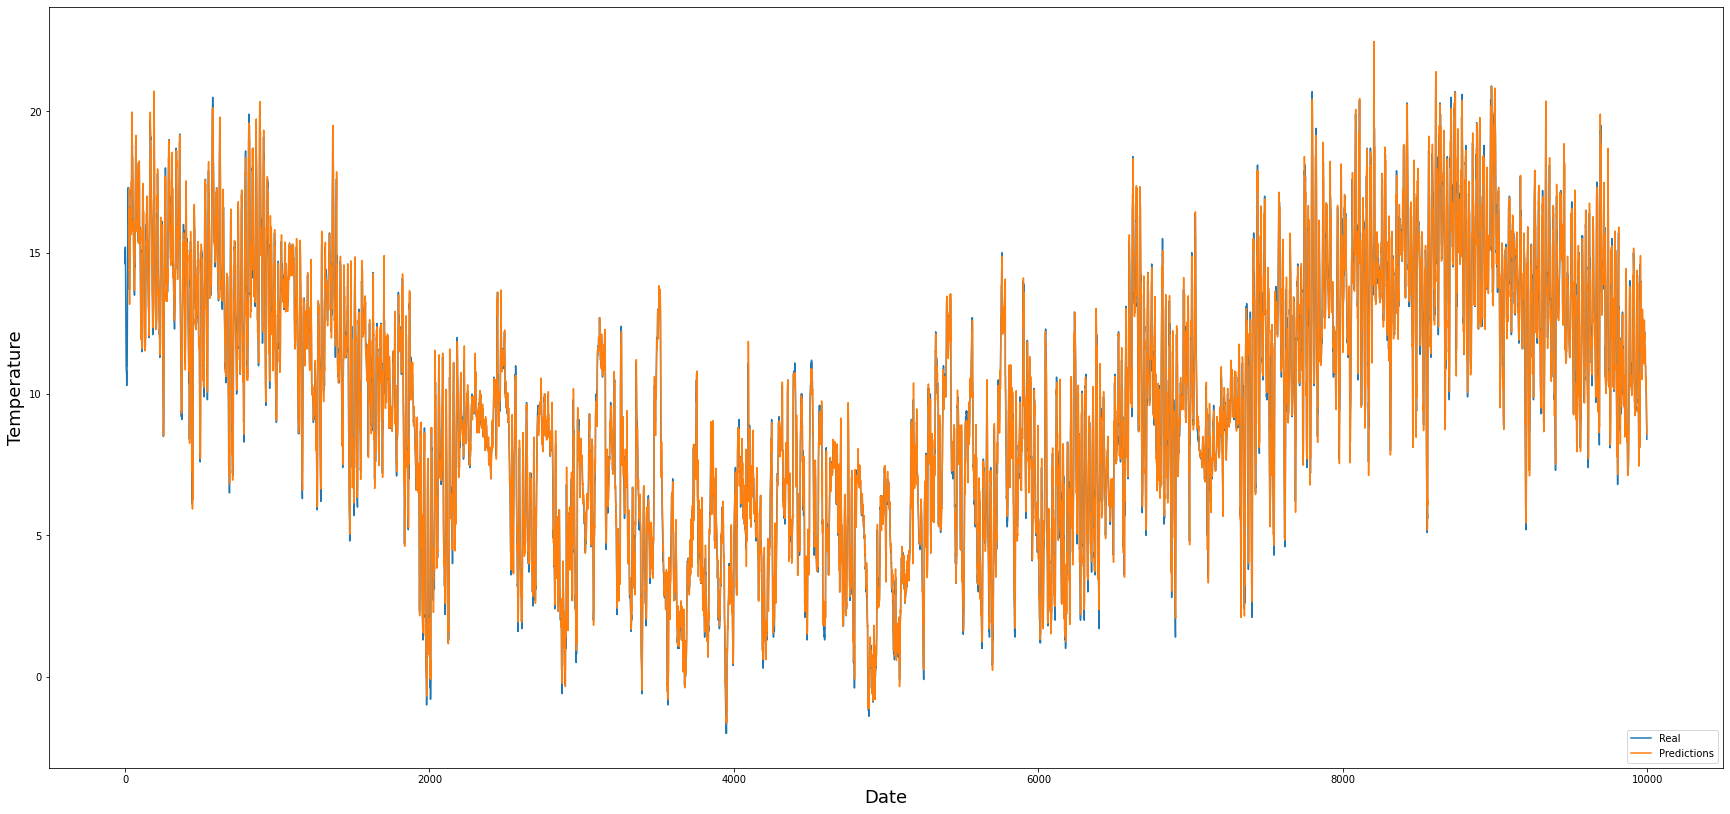

[14.38658]
real	predict	diff
[15.5]	[17.3]	[1.8]
[15.]	[15.]	[0.]
[15.]	[14.4]	[0.6]
[14.4]	[14.4]	[0.]
[14.]	[13.8]	[0.2]
[13.7]	[13.5]	[0.2]
[13.9]	[13.2]	[0.7]
[14.3]	[13.6]	[0.7]
[15.3]	[14.1]	[1.2]
[16.3]	[15.3]	[1.]
[16.4]	[16.4]	[0.]
[16.6]	[16.5]	[0.1]
[16.3]	[16.6]	[0.3]
[16.2]	[16.2]	[0.]
[15.7]	[16.2]	[0.5]
[16.1]	[15.6]	[0.5]
[16.4]	[16.2]	[0.2]
[17.2]	[16.6]	[0.6]
[17.]	[17.5]	[0.5]
[18.1]	[17.]	[1.1]

---------Random Forest---------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:135: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Predictions shape: (9975,)

RMSE: 0.6828117322085773
MSE: 0.4662318616416779
MAE: 0.4902175531296503


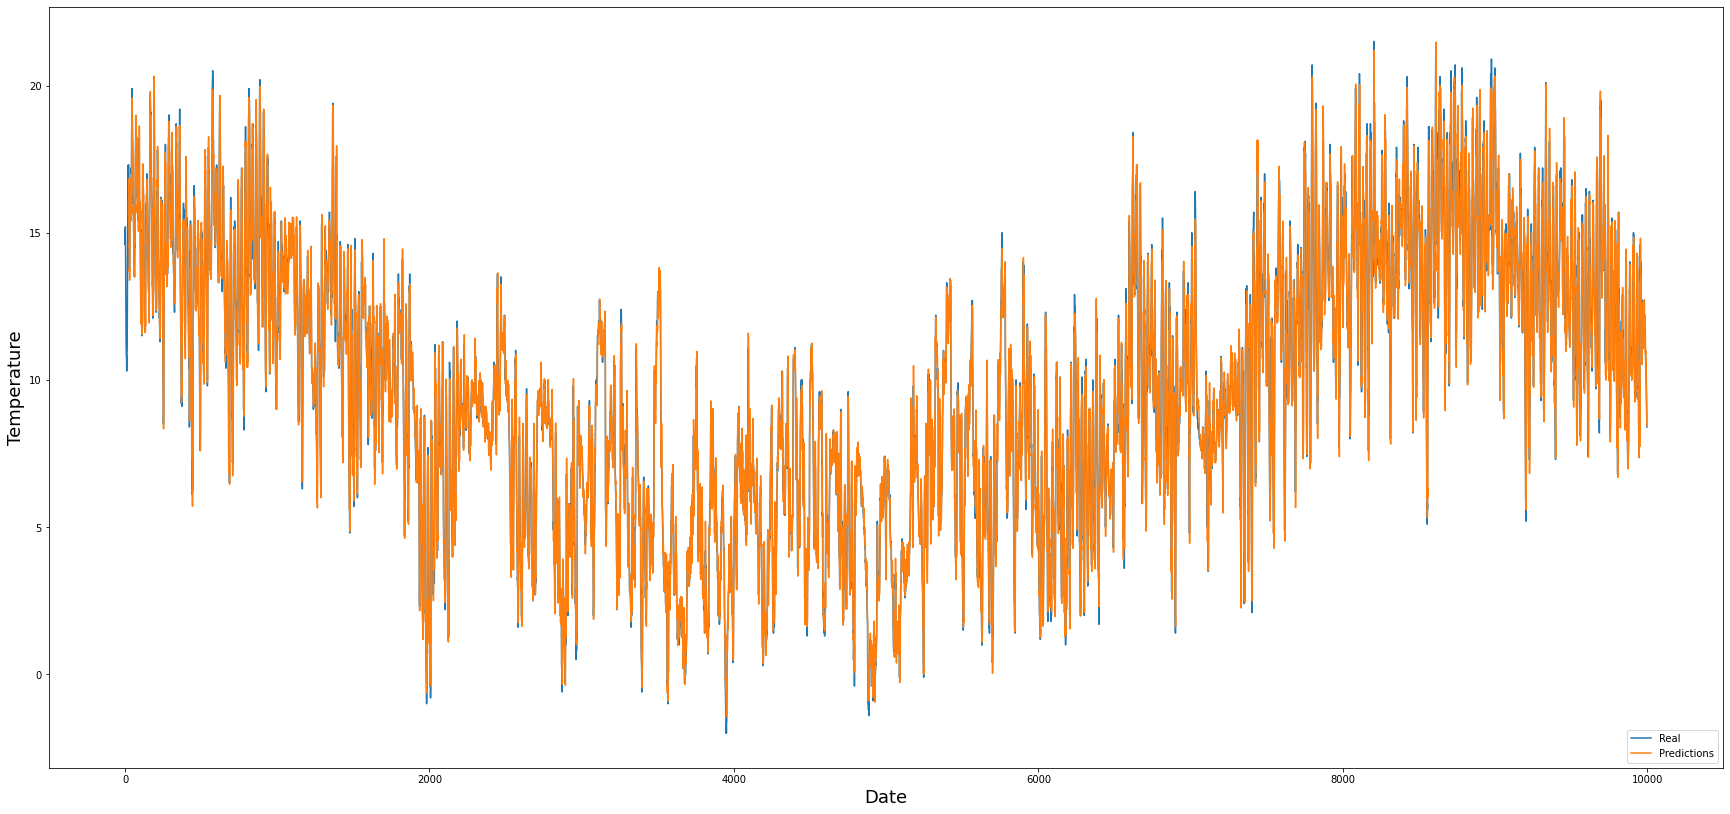

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor 

dataset = weather_stations['Dublin_Airport']
dataset = dataset[:50000].filter(['temp'])

dataset = dataset.fillna(dataset.median())
print(dataset.head(3))

#############################################PREDICTION PARAMETERS#######################################
# na zaklade kolkych hodin dozadu sa bude predpovedat n hodin dopredu
sequence_length = 24
prediction_length = 1
#########################################################################################################

## shift 'temp' data by n hours because of prediction (y label)
temp_shifted = dataset[['temp']]#.shift(-prediction_length)
x_data = dataset.values[0:-prediction_length]
print(f"\nx_data shape: {x_data.shape}")
y_data = temp_shifted.values[:-prediction_length]
print(f"y_data shape: {y_data.shape}")

# train and test set 80:20
training_data_len = math.ceil(len(x_data) * .8)
print(f"Training data len: {training_data_len}, Test data len: {len(x_data)-training_data_len}")
x_train = x_data[0:training_data_len]
x_test = x_data[training_data_len:]
print(f"x_train len: {len(x_train)}, x_test len: {len(x_test)}, count: {len(x_train)+len(x_test)}")
print(f"x_train shape: {x_train.shape}, x_test shape: {x_test.shape}")
y_train = y_data[0:training_data_len]
y_test = y_data[training_data_len:]
print(f"y_train len: {len(y_train)}, y_test len: {len(y_test)}, count: {len(y_train)+len(y_test)}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

#Scale the data
scaler_x = MinMaxScaler(feature_range=(0,1))
x_train_scaled = scaler_x.fit_transform(x_train)
x_test_scaled = scaler_x.transform(x_test)
scaler_y = MinMaxScaler(feature_range=(0,1))
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

###########################################TRAIN DATASET###############################################################
# size of new dataset
_size = training_data_len - sequence_length - prediction_length

x_train_window = np.zeros(shape=(_size, sequence_length, x_data.shape[1]), dtype=np.float16)
y_train_window = np.zeros(shape=(_size, prediction_length, y_data.shape[1]), dtype=np.float16)

for i in range(_size):
  x_train_window[i] = x_train_scaled[i:i+sequence_length]
  y_train_window[i] = y_train_scaled[i+sequence_length:i+sequence_length+prediction_length]

print(f"x_train_window shape:{x_train_window.shape}, y_train_window shape: {y_train_window.shape}")

##########################################VALIDATION DATASET############################################################
#_size = len(x_test) - sequence_length - prediction_length
_size = math.floor((len(x_test) - sequence_length) / prediction_length)

x_valid_window = np.zeros(shape=(_size, sequence_length, x_data.shape[1]), dtype=np.float16)
y_valid_window = np.zeros(shape=(_size, prediction_length, y_data.shape[1]), dtype=np.float16)

ii = 0
for i in range(_size):
  x_valid_window[i] = x_test_scaled[ii:ii+sequence_length]
  y_valid_window[i] = y_test_scaled[ii+sequence_length:ii+sequence_length+prediction_length]
  ii += prediction_length

print(f"x_valid_window shape:{x_valid_window.shape}, y_valid_window shape: {y_valid_window.shape}\n")
#########################################################################################################################

# reshape the data for Linear regression & Random forest
print("Reshaping data:")
x_train_window = x_train_window.reshape(x_train_window.shape[0], x_train_window.shape[1])
y_train_window = y_train_window.reshape(y_train_window.shape[0], y_train_window.shape[1])
print(f"x_train_window shape: {x_train_window.shape}")
print(f"y_train_window shape: {y_train_window.shape}")

x_valid_window = x_valid_window.reshape(x_valid_window.shape[0], x_valid_window.shape[1])
y_valid_window = y_valid_window.reshape(y_valid_window.shape[0], y_valid_window.shape[1])
print(f"x_valid_window shape: {x_valid_window.shape}")
print(f"y_valid_window shape: {y_valid_window.shape}")


##################################################LINEAR REGRESSION#######################################################
print("\n----------Linear regression----------")
# Train and predict
model_lr = LinearRegression()
model_lr.fit(x_train_window, y_train_window);
predictions_lr = model_lr.predict(x_valid_window)

print('Intercept: ', model_lr.intercept_)
print('Coef: ', model_lr.coef_)
print(f"Predictions shape: {predictions_lr.shape}\n")

# predictions_lr = scaler_y.inverse_transform(predictions.reshape(-1,1))
predictions_lr = scaler_y.inverse_transform(predictions_lr)
y_valid_unscaled = scaler_y.inverse_transform(y_valid_window)
predictions_lr = predictions_lr.flatten()
y_valid_unscaled = y_valid_unscaled.flatten()

# calculate metrics
print(f'RMSE: {np.sqrt(mean_squared_error(y_valid_unscaled, predictions_lr))}')
print(f'MSE: {mean_squared_error(y_valid_unscaled, predictions_lr)}')
print(f'MAE: {mean_absolute_error(y_valid_unscaled, predictions_lr)}')
#print('Keras MAPE:', keras.metrics.mean_absolute_percentage_error(y_valid_unscaled, predictions_lr))

#Visualize the predictions
predictions_lr = pd.DataFrame(predictions_lr)
predictions_lr.index = pd.RangeIndex(start=sequence_length, stop = len(predictions_lr)+sequence_length, step = 1)

plt.figure(figsize=(30,14))
plt.xlabel('Date', fontsize=18)
plt.ylabel('Temperature', fontsize=18)
plt.plot(y_test)
plt.plot(predictions_lr)
plt.legend(['Real', 'Predictions'], loc='lower right')
plt.show()

pred_temp = predictions_lr.values
pred_temp = np.array(pred_temp)
print(pred_temp[2])
#Show in table
print("real" + "\t" + "predict" + "\t" + "diff")
for i in range(0, 20):
  result = '---'
  if(str(np.round(abs(y_test[i+24] - pred_temp[i]), 1)) != "0.0"):
    result = str(np.round(abs(y_test[i+24] - pred_temp[i]), 1))
  print(str(y_test[i+24]) + "\t" + str(np.round(pred_temp[i], 1)) + '\t' + result)

#######################################################RANDOM FOREST#################################################
# Train and predict
print("\n---------Random Forest---------")
model_rf = RandomForestRegressor(n_estimators=100)
model_rf.fit(x_train_window, y_train_window);
predictions_rf = model_rf.predict(x_valid_window)

print(f"Predictions shape: {predictions_rf.shape}\n")

if(prediction_length == 1):
  predictions_rf = predictions_rf.reshape(predictions_rf.shape[0], 1)

# predictions_rf = scaler_y.inverse_transform(predictions_rf.reshape(-1,1))
# y_valid_unscaled = scaler_y.inverse_transform(y_valid_window.reshape(-1,1))
# y_valid_unscaled = y_valid_unscaled.flatten()
# predictions_rf = predictions_rf.flatten()

# predictions_rf = scaler_y.inverse_transform(predictions.reshape(-1,1))
predictions_rf = scaler_y.inverse_transform(predictions_rf)
#y_valid_unscaled = scaler_y.inverse_transform(y_valid_window)
predictions_rf = predictions_rf.flatten()
#y_valid_unscaled = y_valid_unscaled.flatten()

# calculate metrics
print(f'RMSE: {np.sqrt(mean_squared_error(y_valid_unscaled, predictions_rf))}')
print(f'MSE: {mean_squared_error(y_valid_unscaled, predictions_rf)}')
print(f'MAE: {mean_absolute_error(y_valid_unscaled, predictions_rf)}')
#print('Keras MAPE:', keras.metrics.mean_absolute_percentage_error(y_valid_unscaled, predictions_rf))

#Visualize the predictions
predictions_rf = pd.DataFrame(predictions_rf)
predictions_rf.index = pd.RangeIndex(start=sequence_length, stop = len(predictions_rf)+sequence_length, step = 1)

plt.figure(figsize=(30,14))
plt.xlabel('Date', fontsize=18)
plt.ylabel('Temperature', fontsize=18)
plt.plot(y_test)
plt.plot(predictions_rf)
plt.legend(['Real', 'Predictions'], loc='lower right')
plt.show()


# Linear regression

#### predicting temperature in another place based on root measure station

In [0]:
from sklearn.model_selection import train_test_split # Using Skicit-learn to split data into training and testing sets
from sklearn.linear_model import LinearRegression # Import the model we are using


# Root measure station
dataset = weather_stations['Dublin_Airport']
dataset = dataset.drop(columns=['station', 'county', 'longitude', 'latitude', 'wetb', 'dewpt'], axis=1)

# Place where is predict temperature
dataset['temp2'] = weather_stations['Casement']['temp'].values #['Shannon_Airport']

#Verify prepared DF
print(dataset.head(10))
dataset = dataset.fillna(dataset.median())

# add time collums
dataset['day'] = dataset.index.dayofyear #1-365 day of year
dataset['hour'] = dataset.index.hour

features = dataset[:30000]

# Labels are the values we want to predict
labels = np.array(features['temp2'])
#print(labels)
# Remove the labels from the features
# axis 1 refers to the columns
features= features.drop('temp2', axis = 1)
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.20, shuffle=False)

from sklearn.preprocessing import PolynomialFeatures 

poly = PolynomialFeatures(degree = ) 
X_poly = poly.fit_transform(train_features)
Y_poly = poly.fit_transform(test_features)
  
poly.fit(X_poly, train_labels) 
lin2 = LinearRegression() 
lin2.fit(X_poly, train_labels)
predictions = lin2.predict(Y_poly)
'''
rf = LinearRegression()
# Train the model on training data
rf.fit(train_features, train_labels);
print('Intercept: ', rf.intercept_)
print('Coef: ', rf.coef_)
# Use the forest's predict method on the test data

predictions = rf.predict(test_features)
'''
print('RMSE', round(np.sqrt(mean_squared_error(test_labels, predictions)), 1))

#Show in table
print("real" + "\t" + "predict" + "\t" + "diff")
for i in range(0, 50):
  result = '---'
  if(str(round(abs(test_labels[i] - predictions[i]), 1)) != "0.0"):
    result = str(round(abs(test_labels[i] - predictions[i]), 1))
  print(str(test_labels[i]) + "\t" + str(round(predictions[i], 1)) + "\t" + result)

#Show graph
df = pd.DataFrame({'Actual': test_labels, 'Predicted': predictions})
df1 = df.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()




                     rain  temp  vappr  rhum  ...     vis   clht  clamt  temp2
date                                          ...                             
1989-01-01 00:00:00   0.0   6.8    8.6  87.0  ...  6000.0  999.0    0.0    7.2
1989-01-01 01:00:00   0.0   7.9    8.4  79.0  ...  8000.0  999.0    0.0    7.4
1989-01-01 02:00:00   0.0   7.9    8.3  78.0  ...  9000.0  999.0    0.0    7.3
1989-01-01 03:00:00   0.0   7.2    8.7  85.0  ...  9000.0  999.0    0.0    7.2
1989-01-01 04:00:00   0.0   6.2    8.5  89.0  ...  9000.0  999.0    0.0    7.3
1989-01-01 05:00:00   0.0   6.0    8.3  89.0  ...  9000.0  999.0    0.0    7.3
1989-01-01 06:00:00   0.0   5.4    8.4  94.0  ...  9000.0  999.0    0.0    6.6
1989-01-01 07:00:00   0.0   6.2    8.5  89.0  ...  9000.0  999.0    0.0    7.1
1989-01-01 08:00:00   0.0   5.4    8.0  89.0  ...  9000.0  999.0    2.0    7.5
1989-01-01 09:00:00   0.0   5.7    8.3  91.0  ...  6000.0  200.0    5.0    7.4

[10 rows x 14 columns]


# Random Forest
#### predicting temperature in another place based on root measure station
https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

(254208, 13)
(254208, 13)
                     rain  temp  vappr  rhum  ...     vis   clht  clamt  temp2
date                                          ...                             
1989-01-01 00:00:00   0.0   6.8    8.6  87.0  ...  6000.0  999.0    0.0    7.2
1989-01-01 01:00:00   0.0   7.9    8.4  79.0  ...  8000.0  999.0    0.0    7.4
1989-01-01 02:00:00   0.0   7.9    8.3  78.0  ...  9000.0  999.0    0.0    7.3
1989-01-01 03:00:00   0.0   7.2    8.7  85.0  ...  9000.0  999.0    0.0    7.2
1989-01-01 04:00:00   0.0   6.2    8.5  89.0  ...  9000.0  999.0    0.0    7.3
1989-01-01 05:00:00   0.0   6.0    8.3  89.0  ...  9000.0  999.0    0.0    7.3
1989-01-01 06:00:00   0.0   5.4    8.4  94.0  ...  9000.0  999.0    0.0    6.6
1989-01-01 07:00:00   0.0   6.2    8.5  89.0  ...  9000.0  999.0    0.0    7.1
1989-01-01 08:00:00   0.0   5.4    8.0  89.0  ...  9000.0  999.0    2.0    7.5
1989-01-01 09:00:00   0.0   5.7    8.3  91.0  ...  6000.0  200.0    5.0    7.4

[10 rows x 14 columns]
MA

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in true_divide


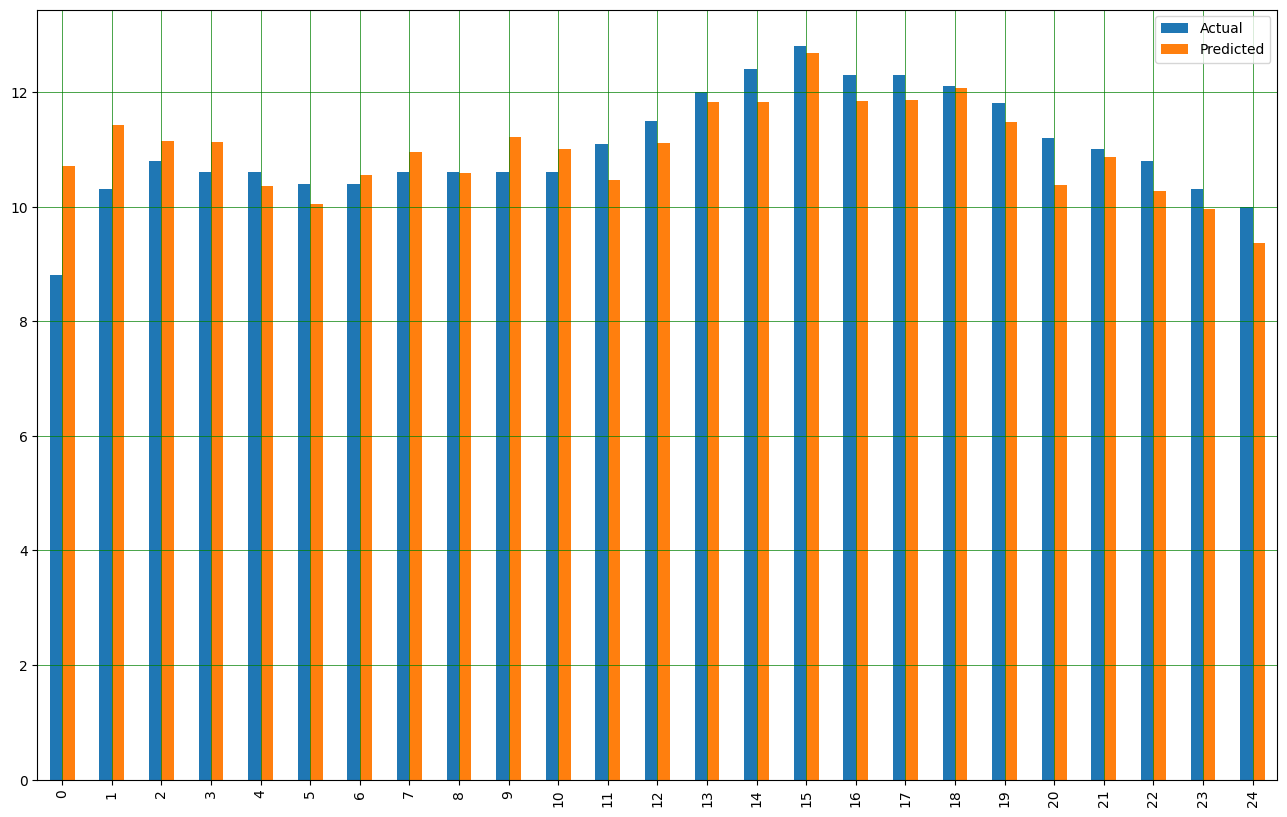

real	predict	diff
8.8	10.7	1.9
10.3	11.4	1.1
10.8	11.1	0.3
10.6	11.1	0.5
10.6	10.4	0.2
10.4	10.1	0.3
10.4	10.6	0.2
10.6	11.0	0.4
10.6	10.6	---
10.6	11.2	0.6
10.6	11.0	0.4
11.1	10.5	0.6
11.5	11.1	0.4
12.0	11.8	0.2
12.4	11.8	0.6
12.8	12.7	0.1
12.3	11.8	0.5
12.3	11.9	0.4
12.1	12.1	---
11.8	11.5	0.3


In [0]:
from sklearn.model_selection import train_test_split # Using Skicit-learn to split data into training and testing sets
from sklearn.ensemble import RandomForestRegressor # Import the model we are using


# Root measure station
dataset = weather_stations['Dublin_Airport']
dataset = dataset.drop(columns=['station', 'county', 'longitude', 'latitude', 'wetb', 'dewpt'], axis=1)
print(dataset.shape)
# Place where is predict temperature
dataset2 = weather_stations['Casement'] #['Shannon_Airport'] #['Casement']
dataset2 = dataset2.drop(columns=['station', 'county', 'longitude', 'latitude', 'wetb', 'dewpt'], axis=1)
print(dataset.shape)
#Add predict temp to root DF
dataset['temp2'] = dataset2['temp']

#Verify prepared DF
print(dataset.head(10))
# dataset = dataset.dropna() #TODO median instead of dropna
dataset = dataset.fillna(dataset.median())

# add time collums
dataset['day'] = dataset.index.dayofyear #1-365 day of year
dataset['hour'] = dataset.index.hour

features = dataset[:30000]

# Labels are the values we want to predict
labels = np.array(features['temp2'])
#print(labels)
# Remove the labels from the features
# axis 1 refers to the columns
features= features.drop('temp2', axis = 1)
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.20, shuffle=False)

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 100)
# Train the model on training data
rf.fit(train_features, train_labels);

# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

print('MAE', round(mean_absolute_error(test_labels, predictions), 2))

'''
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print('MAPE', round(mean_absolute_percentage_error(test_labels, predictions), 2))
'''

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')


# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

#Show graph
df = pd.DataFrame({'Actual': test_labels, 'Predicted': predictions})
df1 = df.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()


#Show in table
print("real" + "\t" + "predict" + "\t" + "diff")
for i in range(0, 20):
  result = '---'
  if(str(round(abs(test_labels[i] - predictions[i]), 1)) != "0.0"):
    result = str(round(abs(test_labels[i] - predictions[i]), 1))
  print(str(test_labels[i]) + "\t" + str(round(predictions[i], 1)) + "\t" + result)
